# **Deep Learning Lab: Understanding Filters**

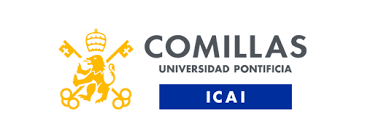

***

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import skimage
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.functional as F
import requests
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

# Convolution Filters

## Load the image

Today we will be working with Chelsea the cat

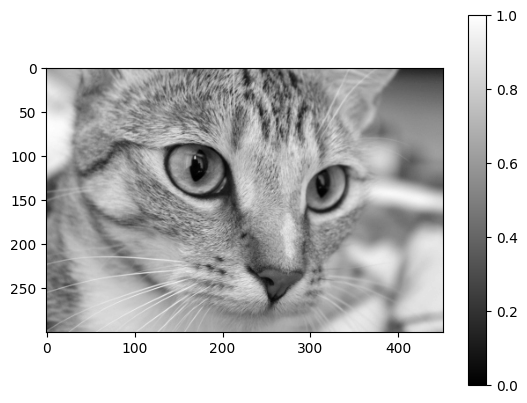

In [11]:
img=skimage.data.chelsea()

# Convert the NumPy array to a PIL Image
img = Image.fromarray(img)

# Convert the image to grayscale
img_gray = transforms.Grayscale(num_output_channels=1)(img)

# Convert the grayscale image to a tensor
img_tensor = transforms.ToTensor()(img_gray)

# Normalize the tensor for plotting
img_tensor = (img_tensor - torch.min(img_tensor)) / (torch.max(img_tensor) - torch.min(img_tensor))

# Display the image
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.colorbar()
plt.show()

## Understanding dimensions

In PyTorch, the Conv2d function takes the following parameters:
- in_channels (int): Number of channels in the input image.
- out_channels (int): Number of channels produced by the convolution.
- kernel_size (int or tuple): Size of the convolving kernel.
- stride (int or tuple, optional): Stride of the convolution.
- padding (int or tuple, optional): Zero-padding added to both sides of the input.

A common choice for filter size is 3x3, as it captures local patterns effectively without adding too many parameters. For padding, same padding (padding = (kernel_size - 1) / 2) is often used to preserve the spatial dimensions of the input. Stride of 1 is the most common choice, but larger strides can be used for downsampling the input or reducing the computational cost.

In general, for squared filters, the output dimensions are given by:

`output_height = ((input_height - kernel_size + padding_height + stride) // stride) + 1`

`output_width = ((input_width - kernel_size + padding_width + stride) // stride) + 1`

In [12]:
# Define a convolutional layer
conv_layer = torch.nn.Conv2d(in_channels=1, 
                             out_channels=1, 
                             kernel_size=3, 
                             stride=1, 
                             padding=1)

# Apply the convolutional layer to the input image tensor
output = conv_layer(img_tensor.unsqueeze(0))

# Print the dimensions
print(f"The original image tensor has size: {img_tensor.size()}") 
print(f"The output tensor has size: {output.squeeze(0).size()}")

The original image tensor has size: torch.Size([1, 300, 451])
The output tensor has size: torch.Size([1, 300, 451])


## Convolution filter examples

In [13]:
def plot_images_and_histogram(original_img, filtered_img, tit1 = 'Original', tit2 = 'Filtered'):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    # Adjusting the layout and padding between subplots
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot original image
    im1 = axes[0].imshow(original_img.squeeze(), cmap='gray')
    axes[0].set_title(tit1)
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], orientation='horizontal', fraction=0.05, pad=0.04)

    # Plot filtered image
    im2 = axes[1].imshow(filtered_img.squeeze(), cmap='gray')
    axes[1].set_title(tit2)
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.04)

    # Plot histogram horizontally
    axes[2].hist(original_img.numpy().flatten(), bins=50, color='c', alpha=0.4, 
                 orientation='horizontal', label=tit1)
    axes[2].hist(filtered_img.numpy().flatten(), bins=50, color='b', alpha=0.4, 
                 orientation='horizontal', label=tit2)
    axes[2].set_title('Histogram')
    axes[2].legend()
    axes[2].axes.get_xaxis().set_visible(False)

    plt.show()


In [14]:
def convolve_and_plot(image, filter, stride=1, padding='same'):
    # Normalize the filter
    filter /= torch.sum(torch.abs(filter))
    # Reshape the filter to match the expected input shape
    filter = filter.unsqueeze(0).unsqueeze(0)
    # Apply the filter to the image tensor
    output_img = torch.nn.functional.conv2d(image.unsqueeze(0), 
                                            filter, 
                                            bias = None,
                                            stride=stride, 
                                            padding=padding)
    # Normalize the output for plotting
    output_img = (output_img - torch.min(output_img)) / (torch.max(output_img) - torch.min(output_img))
    # Plot the images and the histogram
    plot_images_and_histogram(image, output_img)

    return output_img

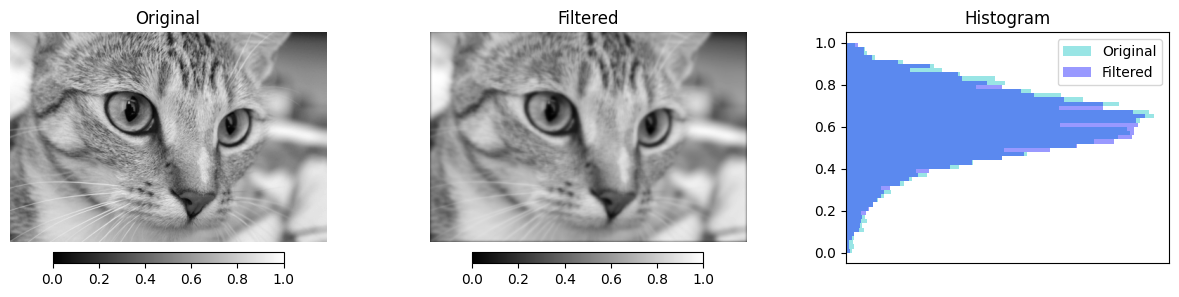

In [20]:
# Definen a gaussian blur filter
gaussian_filter = torch.tensor([[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]], dtype=torch.float)

my_gaussian_filter = torch.tensor([[0.5, 1, 2, 1, 0.5],
                                   [1, 2, 4, 2, 1],
                                   [2, 4, 8, 4, 2],
                                   [1, 2, 4, 2, 1],
                                   [0.5, 1, 2, 1, 0.5]], dtype=torch.float)

your_gaussian_filter = torch.tensor([[0.125, 0.25, 0.5, 1, 2, 1, 0.5, 0.25, 0.125],
                                     [0.25, 0.5, 1, 2, 4, 2, 1, 0.5, 0.25],
                                     [0.5, 1, 2, 4, 8, 4, 2, 1, 0.5],
                                     [1, 2, 4, 8, 16, 8, 4, 2, 1],
                                     [2, 4, 8, 16, 32, 16, 8, 4, 2],
                                     [1, 2, 4, 8, 16, 8, 4, 2, 1],
                                     [0.5, 1, 2, 4, 8, 4, 2, 1, 0.5],
                                     [0.25, 0.5, 1, 2, 4, 2, 1, 0.5, 0.25],
                                     [0.125, 0.25, 0.5, 1, 2, 1, 0.5, 0.25, 0.125]], dtype=torch.float)

_ = convolve_and_plot(img_tensor, your_gaussian_filter)

In [86]:
# The filter doesn't seem to be blurring much. Why is that? How could we increase the blurring effect?

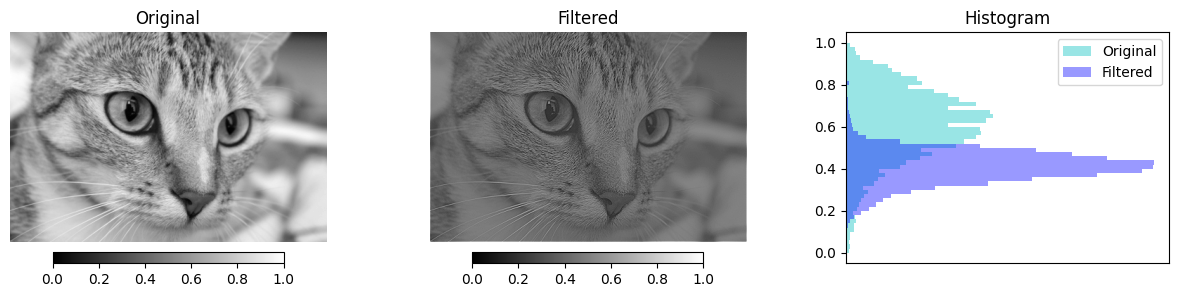

In [27]:
# Define a sharpen filter
sharpen_filter = torch.tensor([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]], dtype=torch.float)

_ = convolve_and_plot(img_tensor, sharpen_filter)

In [88]:
# Do you see the image sharper (more focused)? Why is that? Can you improve the sharpening effect?

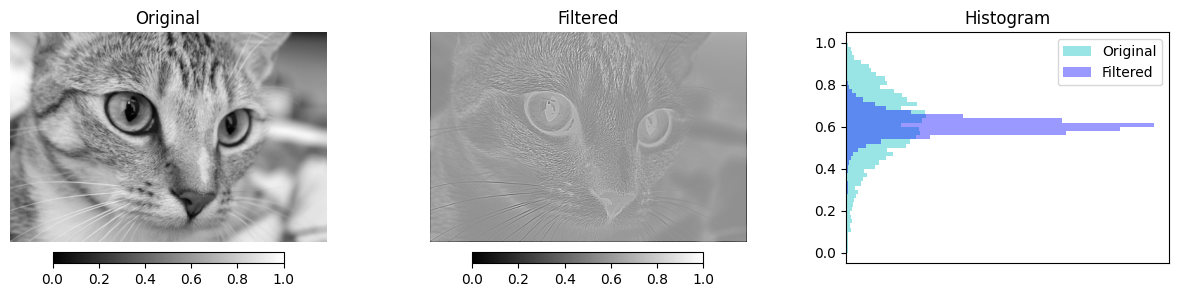

In [36]:
# Define an edge detection filter
edge_filter = torch.tensor([[1, 1, 1],
                            [1, -9, 1],
                            [1, 1, 1]], dtype=torch.float)

_ = convolve_and_plot(img_tensor, edge_filter)

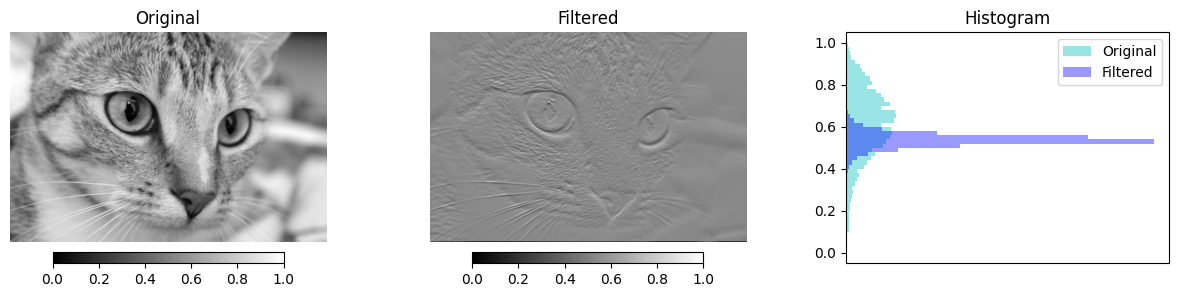

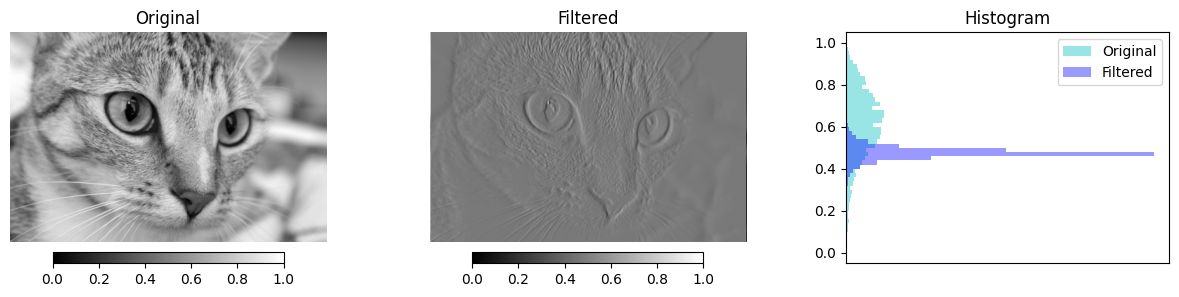

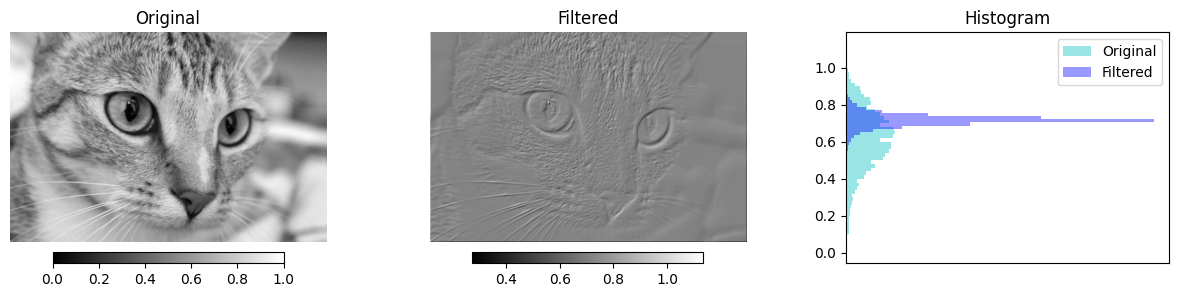

In [31]:
# Define sobel filters for horizontal and vertical edges
sobel_horizontal = torch.tensor([[-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]], dtype=torch.float)

sobel_vertical = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]], dtype=torch.float)

sobel_h = convolve_and_plot(img_tensor, sobel_horizontal)
sobel_v = convolve_and_plot(img_tensor, sobel_vertical)

# Combine the horizontal and vertical edges
sobel_combined = torch.sqrt(sobel_h**2 + sobel_v**2)
plot_images_and_histogram(img_tensor, sobel_combined)

## Hybrid images

With high and low pass filters, it is possible to create hybrid images that are perceived in one of two different ways, depending on viewing distance, based on the way humans process visual input.

In [32]:
def get_image_from_url(url, resize=True):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    if resize:
        img = cv2.resize(img, (1280, 840))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [33]:
road_img, road_img_float, road_tensor = get_image_from_url("https://cdn.pixabay.com/photo/2018/02/27/18/17/road-3186188_1280.jpg", False)
tree_img, tree_img_float, tree_tensor = get_image_from_url("https://cdn.mos.cms.futurecdn.net/ARWms77gyVZ5u2MZkQqcKc-1200-80.jpg", True)

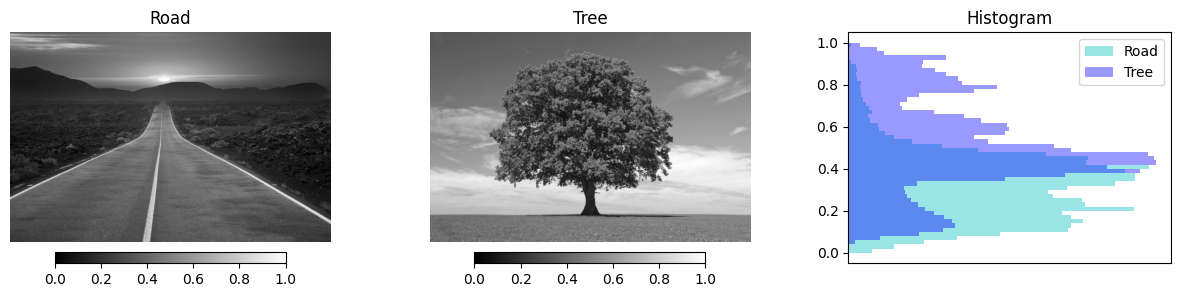

The road image has size: torch.Size([1, 840, 1280])
The tree image has size: torch.Size([1, 840, 1280])


In [34]:
road_gray = transforms.Grayscale(num_output_channels=1)(Image.fromarray(road_img))
road_gray = transforms.ToTensor()(road_gray)
road_gray = (road_gray - torch.min(road_gray)) / (torch.max(road_gray) - torch.min(road_gray))

tree_gray = transforms.Grayscale(num_output_channels=1)(Image.fromarray(tree_img))
tree_gray = transforms.ToTensor()(tree_gray)
tree_gray = (tree_gray - torch.min(tree_gray)) / (torch.max(tree_gray) - torch.min(tree_gray))

# Plot the images
plot_images_and_histogram(road_gray, tree_gray, tit1='Road', tit2='Tree')

# Sizes of the images
print(f"The road image has size: {road_gray.size()}")
print(f"The tree image has size: {tree_gray.size()}")

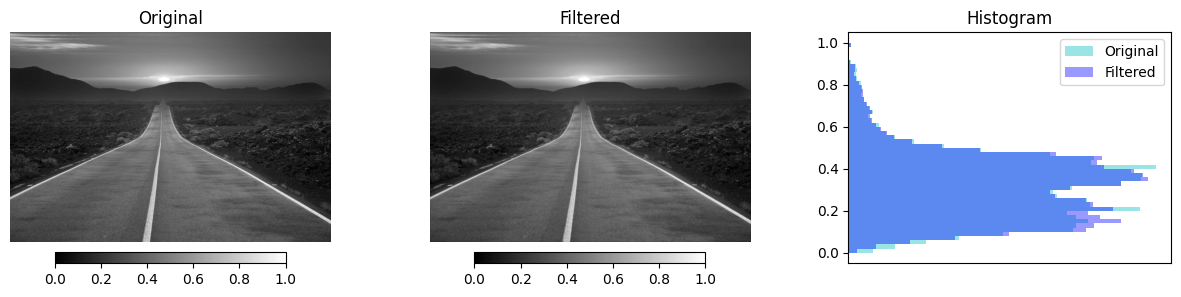

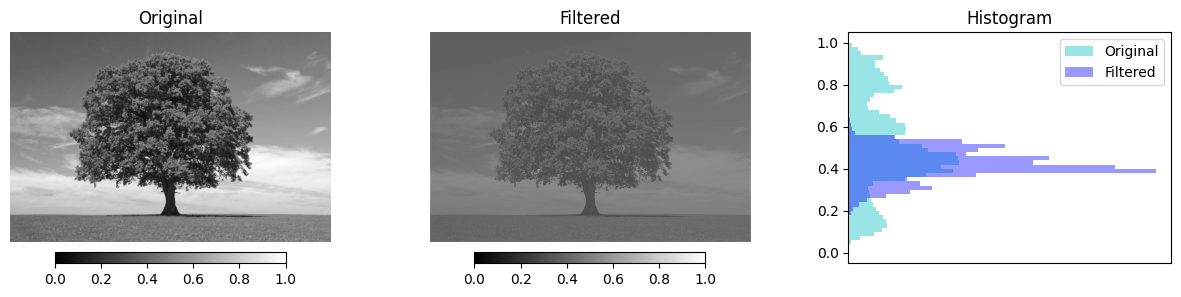

In [42]:
low_pass_filter = gaussian_filter
high_pass_filter = sharpen_filter

road_low_pass = convolve_and_plot(road_gray, low_pass_filter)
tree_high_pass = convolve_and_plot(tree_gray, high_pass_filter)



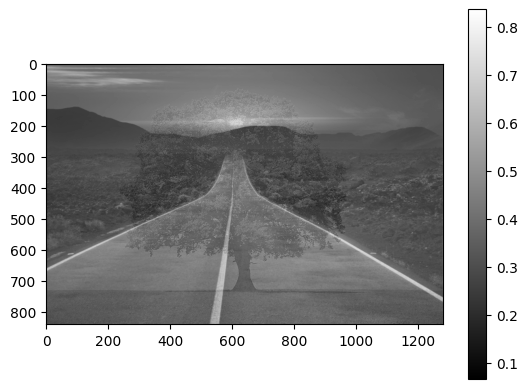

In [43]:
hybrid_img = (road_low_pass + tree_high_pass) / 2

hybrid_img = np.clip(hybrid_img, 0, 1)
plt.imshow(hybrid_img.squeeze(), cmap='gray')
plt.colorbar()
plt.show()


In [116]:
# The tree doesn't seem to be very visible in the hybrid image. 
# Can you think of a way to improve this?
# Try it out with your own images!

# Max pooling: Dimensionality reduction

In [44]:
def max_pool_and_plot(image, kernel_size=2, stride=2):
    # Apply max pooling to the image tensor
    output_img = torch.nn.functional.max_pool2d(image.unsqueeze(0), kernel_size=kernel_size, stride=stride)

    # Normalize the output for plotting
    output_img = (output_img - torch.min(output_img)) / (torch.max(output_img) - torch.min(output_img))

    # Plot the images and the histogram
    plot_images_and_histogram(image, output_img.squeeze())

    print(f"The original image size is: {image.squeeze().size()} and the output image size is: {output_img.squeeze().size()}")
    return output_img.squeeze(dim=0)


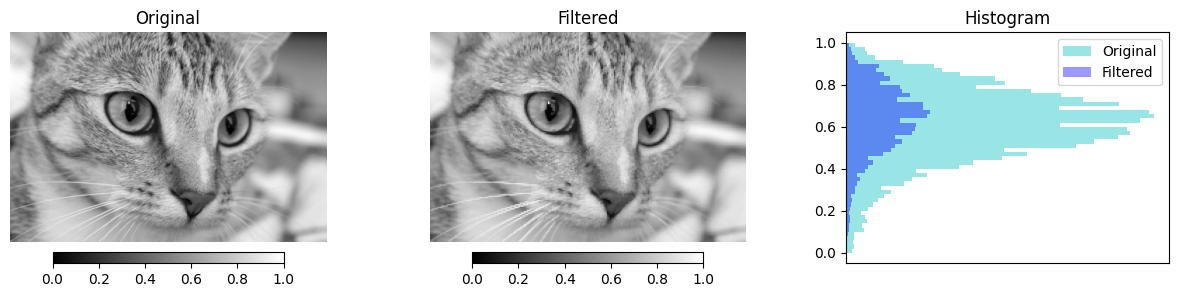

The original image size is: torch.Size([300, 451]) and the output image size is: torch.Size([150, 225])


In [45]:
reduced_img = max_pool_and_plot(img_tensor)

In [46]:
# How can we incrase the dimensionality reduction effect of the max pooling layer?

# CNNs interpretability

In this section we will be using Grad-CAM (https://arxiv.org/abs/1610.02391) to answer the following question:

“What in the image is similar, or different, than the reference embedding?”

In [47]:
def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [48]:
car_img, car_img_float, car_tensor = get_image_from_url("https://cdni.autocarindia.com/utils/imageresizer.ashx?n=https://cms.haymarketindia.net/model/uploads/modelimages/Hyundai-Grand-i10-Nios-200120231541.jpg&w=350&h=251&q=91&c=1")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_url("https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1")

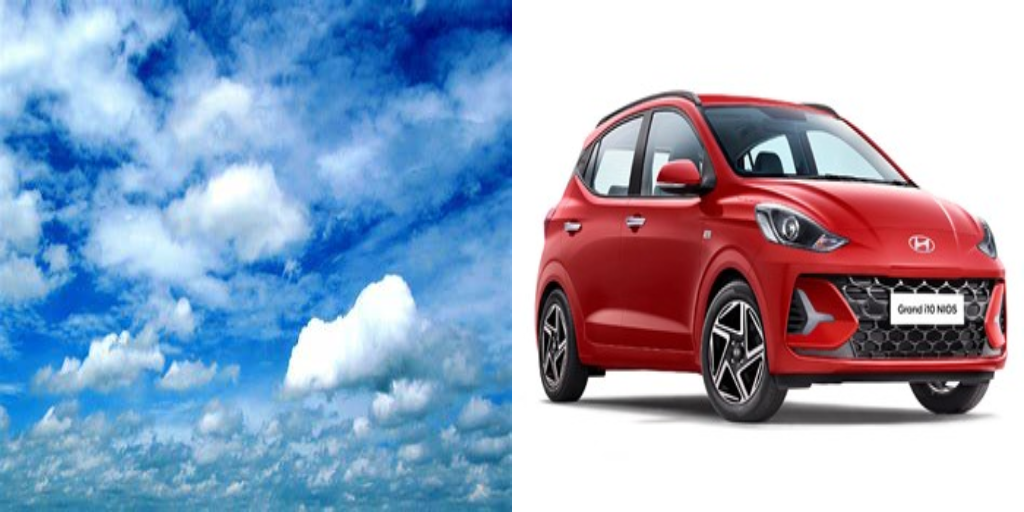

In [49]:
Image.fromarray(np.hstack((cloud_img, car_img)))

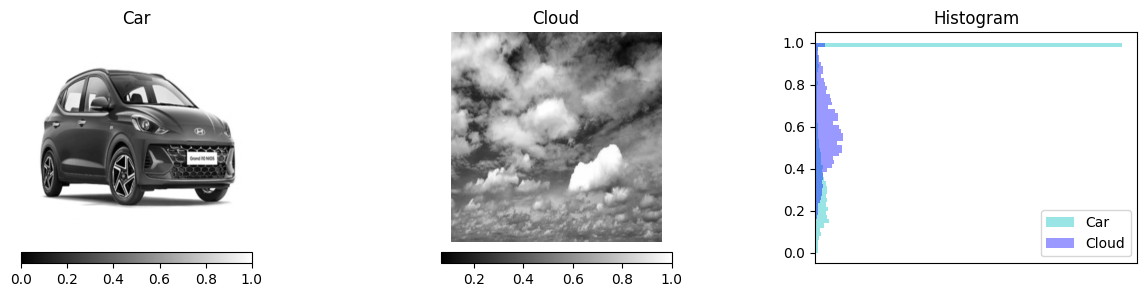

In [50]:
car_grayscale_img = transforms.Grayscale(num_output_channels=1)(transforms.ToPILImage()(car_img_float))
cloud_grayscale_img = transforms.Grayscale(num_output_channels=1)(transforms.ToPILImage()(cloud_img_float))
plot_images_and_histogram(torchvision.transforms.ToTensor()(car_grayscale_img), torchvision.transforms.ToTensor()(cloud_grayscale_img),
                          tit1='Car', tit2='Cloud')

In [51]:
# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
        
# Load a pretrained resnet model (https://pytorch.org/vision/0.17/_modules/torchvision/models/resnet.html)
resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval()
model = ResnetFeatureExtractor(resnet)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/raul/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.69MB/s]


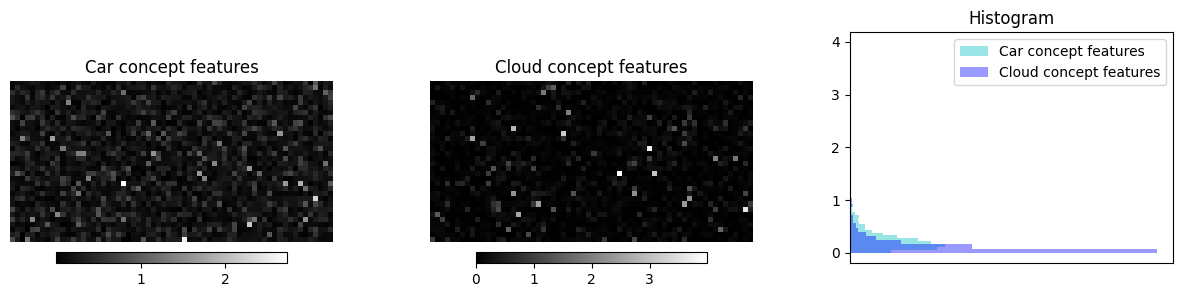

In [52]:
# Obtain the concept features of the images
car_concept_features = model(car_tensor)[0, :]
cloud_concept_features = model(cloud_tensor)[0, :]

# Plot the images and the histogram
car_concept_features_img = car_concept_features.detach().numpy().reshape(32, 64)
cloud_concept_features_img = cloud_concept_features.detach().numpy().reshape(32, 64)
plot_images_and_histogram(torch.tensor(car_concept_features_img), 
                          torch.tensor(cloud_concept_features_img),
                          tit1="Car concept features",
                          tit2="Cloud concept features")

In [53]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

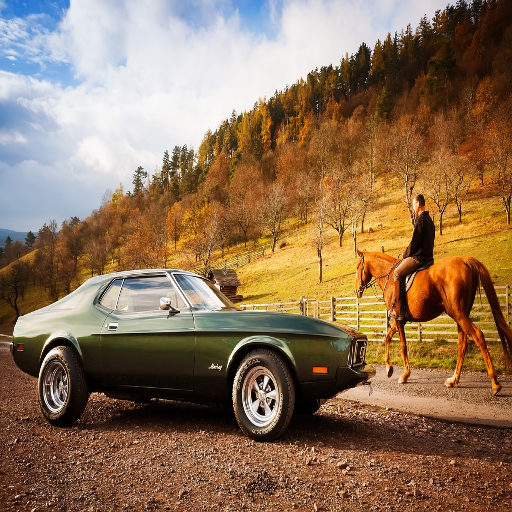

In [54]:
image, image_float, input_tensor = get_image_from_url("https://jacobgil.github.io/pytorch-gradcam-book/_images/Pixel%20Attribution%20for%20embeddings_7_0.png")
Image.fromarray(image)

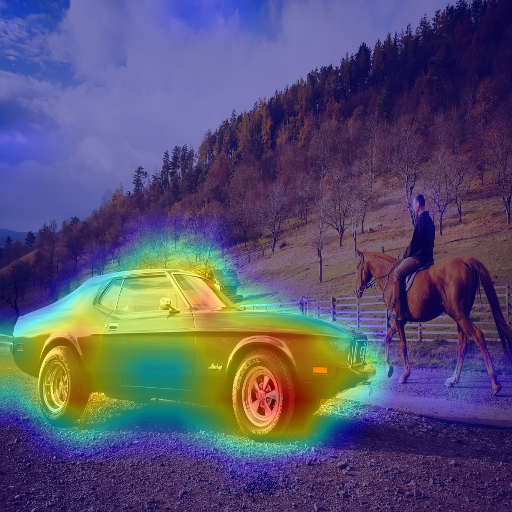

In [55]:
# Where is the car in the image
target_layers = [resnet.layer4[-1]] # What is this layer?
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

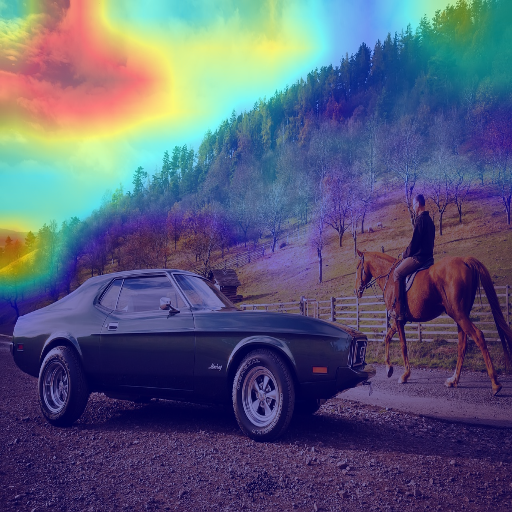

In [56]:
# Where is the cloud in the image
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

In [119]:
# What is the algorithm doing under the hood? 

# Try it out with your own images!